# Lab 6 Part 1: Advanced Model Analysis & Persistence

**Course:** SRT521 - Advanced Data Analysis for Security  
**Week:** 6 of 14  
**Instructor:** Hamed Haddadpajouh, PhD  
**Lab Duration:** 3 hours  
**Type:** Individual Assignment  
**Competition Points:** Advanced analysis techniques and model optimization

## Learning Objectives
By the end of this lab, you will be able to:
- Perform comprehensive error analysis with detailed visualizations
- Implement cross-validation for both supervised and unsupervised learning
- Fine-tune hyperparameters using grid search and random search
- Save and load models using pickle files
- Compare model performance across different configurations
- Apply advanced evaluation techniques to security datasets

## Prerequisites
- Completed Labs 1-5 (EDA, cleaning, feature engineering, baseline ML, model evaluation)
- Understanding of machine learning evaluation metrics
- Python libraries for visualization and model persistence

---


# Part 1: Setup and Data Preparation 🎯

We will work with a comprehensive security dataset to demonstrate advanced analysis techniques.


## 1.1 Import Required Libraries


In [4]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                           accuracy_score, precision_score, recall_score, f1_score,
                           silhouette_score, adjusted_rand_score)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print('All libraries imported successfully!')
print(f'Current working directory: {os.getcwd()}')


All libraries imported successfully!
Current working directory: c:\Users\gurma\Downloads


## 1.2 Load Dataset




In [8]:
# ============================================================================
# Lab 6 Part 1.2: Load Your Phishing Dataset
# ============================================================================

# Load phishing dataset
df = pd.read_csv('C:\\Users\\gurma\\Downloads\\engineered_dataset4.csv')

print('✅ Dataset loaded successfully!')
print('='*70)

# Dataset overview
print(f'\n📊 DATASET OVERVIEW:')
print(f'   Shape: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Display column names
print(f'\n📋 COLUMNS ({len(df.columns)} total):')
for i, col in enumerate(df.columns, 1):
    print(f'   {i:2d}. {col}')

# Check for missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    print(f'\n⚠️  Missing values detected: {missing_count} total')
    print(f'   Columns with missing data:')
    missing_cols = df.isnull().sum()
    for col, count in missing_cols[missing_cols > 0].items():
        print(f'      • {col}: {count} ({count/len(df)*100:.1f}%)')
else:
    print(f'\n✅ No missing values detected')

# Display first few rows
print(f'\n📝 FIRST 5 ROWS:')
print('='*70)
display(df.head())

# Display data types
print(f'\n🔢 DATA TYPES:')
print(df.dtypes.value_counts())

# Check for the target column (label)
if 'label' in df.columns:
    print(f'\n🎯 TARGET VARIABLE (label):')
    print(f'   Class distribution:')
    label_counts = df['label'].value_counts()
    for label, count in label_counts.items():
        print(f'      • Class {label}: {count} ({count/len(df)*100:.1f}%)')

    # Check if balanced
    balance_ratio = label_counts.min() / label_counts.max()
    if balance_ratio < 0.5:
        print(f'   ⚠️  Imbalanced dataset detected (ratio: {balance_ratio:.2f})')
        print(f'      → Stratified sampling will be used')
    else:
        print(f'   ✅ Reasonably balanced dataset (ratio: {balance_ratio:.2f})')
else:
    print(f'\n⚠️  WARNING: "label" column not found!')
    print(f'   Available columns: {df.columns.tolist()}')
    print(f'   Please verify your target column name.')

print('\n' + '='*70)

✅ Dataset loaded successfully!

📊 DATASET OVERVIEW:
   Shape: 235795 rows × 68 columns
   Memory usage: 187.76 MB

📋 COLUMNS (68 total):
    1. FILENAME
    2. URL
    3. URLLength
    4. Domain
    5. DomainLength
    6. IsDomainIP
    7. TLD
    8. URLSimilarityIndex
    9. CharContinuationRate
   10. TLDLegitimateProb
   11. URLCharProb
   12. TLDLength
   13. NoOfSubDomain
   14. HasObfuscation
   15. NoOfObfuscatedChar
   16. ObfuscationRatio
   17. NoOfLettersInURL
   18. LetterRatioInURL
   19. NoOfDegitsInURL
   20. DegitRatioInURL
   21. NoOfEqualsInURL
   22. NoOfQMarkInURL
   23. NoOfAmpersandInURL
   24. NoOfOtherSpecialCharsInURL
   25. SpacialCharRatioInURL
   26. IsHTTPS
   27. LineOfCode
   28. LargestLineLength
   29. HasTitle
   30. Title
   31. DomainTitleMatchScore
   32. URLTitleMatchScore
   33. HasFavicon
   34. Robots
   35. IsResponsive
   36. NoOfURLRedirect
   37. NoOfSelfRedirect
   38. HasDescription
   39. NoOfPopup
   40. NoOfiFrame
   41. HasExternalForm

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Content_Quality_Score,Suspicious_Elements_Count,Financial_Keywords,Security_Risk_Score,External_Dependency_Ratio,Empty_Links_Ratio,URL_Domain_Length_Ratio,Content_URL_Ratio,Title_Match_Diff,Tech_Sophistication
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,17,2,1,13,0.510288,0.000000,1.240000,17.437500,0.0,38.0
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,16,0,0,0,0.847656,0.000000,1.352941,25.750000,0.0,17.1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,23,1,0,5,0.106383,0.040816,1.260870,15.566667,0.0,11.9
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,20,14,2,21,0.584906,0.018519,1.300000,235.407407,0.0,29.3
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,26,5,2,21,0.541401,0.006329,1.222222,179.088235,0.0,60.7



🔢 DATA TYPES:
int64      45
float64    18
object      5
Name: count, dtype: int64

🎯 TARGET VARIABLE (label):
   Class distribution:
      • Class 1: 134850 (57.2%)
      • Class 0: 100945 (42.8%)
   ✅ Reasonably balanced dataset (ratio: 0.75)



## 1.3 Data Splitting and Preprocessing



In [ ]:
# ============================================================================
# 1.3 Data Splitting and Preprocessing (FINAL - ALL LEAKAGE REMOVED)
# ============================================================================

print('🔧 DATA PREPROCESSING & SPLITTING')
print('='*70)

# ============================================================================
# IMPORTANT: Remove ALL data leakage features!
# ============================================================================

leakage_features = [
    # Original engineered features (from lab 3)
    'Security_Risk_Score',       
    'Suspicious_Elements_Count', 
    'Financial_Keywords',        
    'URL_Complexity_Score',      
    'Domain_Trust_Score',        
    'Content_Quality_Score',     
    'URLSimilarityIndex',        
    'HasSocialNet',              
    'HasCopyrightInfo',          
    'IsHTTPS'                    
]

print(f'\n🚨 REMOVING ALL DATA LEAKAGE FEATURES ({len(leakage_features)} total):')
for feat in leakage_features:
    if feat in df.columns:
        print(f'   • {feat}')

# Identifier columns to remove
identifier_columns = ['FILENAME', 'URL', 'Domain', 'Title', 'TLD']

print(f'\n📌 Removing identifier columns:')
for col in identifier_columns:
    if col in df.columns:
        print(f'   • {col}')

# Combine all columns to remove
all_columns_to_remove = identifier_columns + leakage_features

# ============================================================================
# Separate features and target
# ============================================================================

# FIRST: Remove rows with missing labels!
print(f'\n🔧 Checking for missing labels...')
print(f'   Original dataset: {df.shape[0]} rows')
df_clean = df.dropna(subset=['label'])
print(f'   After removing missing labels: {df_clean.shape[0]} rows')
print(f'   Removed: {df.shape[0] - df_clean.shape[0]} row(s)')

X = df_clean.drop(columns=all_columns_to_remove + ['label'], errors='ignore')
y = df_clean['label']

print(f'\n✅ Features extracted:')
print(f'   • Original columns: {df_clean.shape[1]}')
print(f'   • Removed columns: {len(all_columns_to_remove) + 1}')
print(f'   • Remaining features: {X.shape[1]}')
print(f'   • Feature matrix: {X.shape}')
print(f'   • Target vector: {y.shape}')

# ============================================================================
# Handle any non-numeric columns
# ============================================================================

non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f'\n⚠️  Converting non-numeric columns...')
    for col in non_numeric_cols:
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        except:
            X = X.drop(columns=[col])

# Fill any NaN values
if X.isnull().sum().sum() > 0:
    print(f'\n🔧 Filling {X.isnull().sum().sum()} missing values with 0...')
    X = X.fillna(0)

print(f'\n✅ Final feature count: {X.shape[1]}')

# ============================================================================
# Split data for binary classification
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\n📊 Train-Test Split:')
print(f'   • Training set: {X_train.shape[0]} samples')
print(f'   • Test set:     {X_test.shape[0]} samples')

# Check class distribution
train_dist = y_train.value_counts()
test_dist = y_test.value_counts()

print(f'\n   Training distribution:')
print(f'      Class 0: {train_dist.get(0.0, 0)} ({train_dist.get(0.0, 0)/len(y_train)*100:.1f}%)')
print(f'      Class 1: {train_dist.get(1.0, 0)} ({train_dist.get(1.0, 0)/len(y_train)*100:.1f}%)')

print(f'   Test distribution:')
print(f'      Class 0: {test_dist.get(0.0, 0)} ({test_dist.get(0.0, 0)/len(y_test)*100:.1f}%)')
print(f'      Class 1: {test_dist.get(1.0, 0)} ({test_dist.get(1.0, 0)/len(y_test)*100:.1f}%)')

# ============================================================================
# Scale features
# ============================================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'\n⚖️  Feature Scaling:')
print(f'   • Training data scaled: {X_train_scaled.shape}')
print(f'   • Test data scaled:     {X_test_scaled.shape}')

# ============================================================================
# Display split summary
# ============================================================================

print(f'\n📋 FINAL SUMMARY:')
print(f'   • Features used: {X_train.shape[1]}')
print(f'   • Training samples: {X_train.shape[0]}')
print(f'   • Test samples: {X_test.shape[0]}')
print(f'   • Total leakage features removed: {len(leakage_features)}')

print('\n✅ Data preprocessing complete!')
print('   Models should now show REALISTIC performance!')
print('='*70)

🔧 DATA PREPROCESSING & SPLITTING

🚨 REMOVING ALL DATA LEAKAGE FEATURES (10 total):
   • Security_Risk_Score
   • Suspicious_Elements_Count
   • Financial_Keywords
   • URL_Complexity_Score
   • Domain_Trust_Score
   • Content_Quality_Score
   • URLSimilarityIndex
   • HasSocialNet
   • HasCopyrightInfo
   • IsHTTPS

📌 Removing identifier columns:
   • FILENAME
   • URL
   • Domain
   • Title
   • TLD

🔧 Checking for missing labels...
   Original dataset: 235795 rows
   After removing missing labels: 235795 rows
   Removed: 0 row(s)

✅ Features extracted:
   • Original columns: 68
   • Removed columns: 16
   • Remaining features: 52
   • Feature matrix: (235795, 52)
   • Target vector: (235795,)

✅ Final feature count: 52

📊 Train-Test Split:
   • Training set: 188636 samples
   • Test set:     47159 samples

   Training distribution:
      Class 0: 80756 (42.8%)
      Class 1: 107880 (57.2%)
   Test distribution:
      Class 0: 20189 (42.8%)
      Class 1: 26970 (57.2%)

⚖️  Feature Sc

# Part 2: Comprehensive Error Analysis 🔍

Error analysis is crucial for understanding model behavior and improving performance. We'll analyze different types of errors and their patterns.


## 2.1 Train Baseline Models for Error Analysis


In [10]:
# ============================================================================
# Part 2: Comprehensive Error Analysis 🔍
# 2.1 Train Baseline Models for Error Analysis
# ============================================================================

print('='*70)
print('PART 2: TRAINING BASELINE MODELS')
print('='*70)

# Train multiple models for comparison (SVM excluded for speed)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
}

# Train models and store predictions
model_predictions = {}
model_probabilities = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for Logistic Regression
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    model_predictions[name] = y_pred
    model_probabilities[name] = y_prob

    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

print("\n" + "="*70)
print("✅ All models trained successfully!")
print("="*70)

# Create performance comparison table
print('\n📊 MODEL PERFORMANCE COMPARISON:')
print('='*70)

performance_data = []
for name in models.keys():
    y_pred = model_predictions[name]
    performance_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

perf_df = pd.DataFrame(performance_data)
perf_df = perf_df.round(4)
print(perf_df.to_string(index=False))
print('='*70)

# Find best model
best_model_name = perf_df.loc[perf_df['F1 Score'].idxmax(), 'Model']
best_f1 = perf_df['F1 Score'].max()
print(f'\n🏆 Best Model: {best_model_name} (F1 Score: {best_f1:.4f})')

PART 2: TRAINING BASELINE MODELS

Training Random Forest...
  Accuracy:  0.9992
  Precision: 0.9989
  Recall:    0.9998
  F1 Score:  0.9993

Training Logistic Regression...
  Accuracy:  0.9976
  Precision: 0.9983
  Recall:    0.9975
  F1 Score:  0.9979

Training XGBoost...
  Accuracy:  0.9996
  Precision: 0.9995
  Recall:    0.9998
  F1 Score:  0.9997

✅ All models trained successfully!

📊 MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision  Recall  F1 Score
      Random Forest    0.9992     0.9989  0.9998    0.9993
Logistic Regression    0.9976     0.9983  0.9975    0.9979
            XGBoost    0.9996     0.9995  0.9998    0.9997

🏆 Best Model: XGBoost (F1 Score: 0.9997)


## 2.2 Detailed Error Analysis with Visualizations


In [11]:
# ============================================================================
# Part 2.2: Detailed Error Analysis with Visualizations
# ============================================================================

def analyze_errors(model_name, y_true, y_pred, X_test_data):
    """
    Comprehensive error analysis for a given model
    """
    print(f"\n=== Error Analysis for {model_name} ===")

    # Get misclassified samples
    misclassified_mask = y_true != y_pred
    misclassified_indices = np.where(misclassified_mask)[0]

    # False Positives (Legitimate predicted as Phishing)
    fp_mask = (y_true == 0.0) & (y_pred == 1.0)
    fp_indices = np.where(fp_mask)[0]

    # False Negatives (Phishing predicted as Legitimate)
    fn_mask = (y_true == 1.0) & (y_pred == 0.0)
    fn_indices = np.where(fn_mask)[0]

    print(f"Total misclassified: {len(misclassified_indices)}")
    print(f"False Positives (Legit → Phishing): {len(fp_indices)}")
    print(f"False Negatives (Phishing → Legit): {len(fn_indices)}")

    # Analyze feature patterns in errors
    if len(fp_indices) > 0:
        fp_features = X_test_data.iloc[fp_indices]
        print(f"\nFalse Positive Analysis:")
        print(f"Mean values of FP samples:")
        print(fp_features.mean().sort_values(ascending=False).head())

    if len(fn_indices) > 0:
        fn_features = X_test_data.iloc[fn_indices]
        print(f"\nFalse Negative Analysis:")
        print(f"Mean values of FN samples:")
        print(fn_features.mean().sort_values(ascending=False).head())

    return fp_indices, fn_indices

# Analyze errors for each model
error_analysis = {}
for model_name in models.keys():
    fp_indices, fn_indices = analyze_errors(
        model_name, y_test, model_predictions[model_name], X_test
    )
    error_analysis[model_name] = {'fp_indices': fp_indices, 'fn_indices': fn_indices}

print("\n" + "="*70)
print("✅ Error analysis complete!")
print("="*70)


=== Error Analysis for Random Forest ===
Total misclassified: 37
False Positives (Legit → Phishing): 31
False Negatives (Phishing → Legit): 6

False Positive Analysis:
Mean values of FP samples:
LargestLineLength        8621.548387
LineOfCode                248.000000
URLTitleMatchScore         83.064516
DomainTitleMatchScore      83.064516
URLLength                  25.709677
dtype: float64

False Negative Analysis:
Mean values of FN samples:
LargestLineLength        1030.666667
LineOfCode                141.500000
URLTitleMatchScore         83.333333
DomainTitleMatchScore      83.333333
URLLength                  24.166667
dtype: float64

=== Error Analysis for Logistic Regression ===
Total misclassified: 114
False Positives (Legit → Phishing): 47
False Negatives (Phishing → Legit): 67

False Positive Analysis:
Mean values of FP samples:
LargestLineLength        6968.510638
LineOfCode                215.425532
URLTitleMatchScore         80.319149
DomainTitleMatchScore      80.319149


PART 2.3: ERROR VISUALIZATIONS


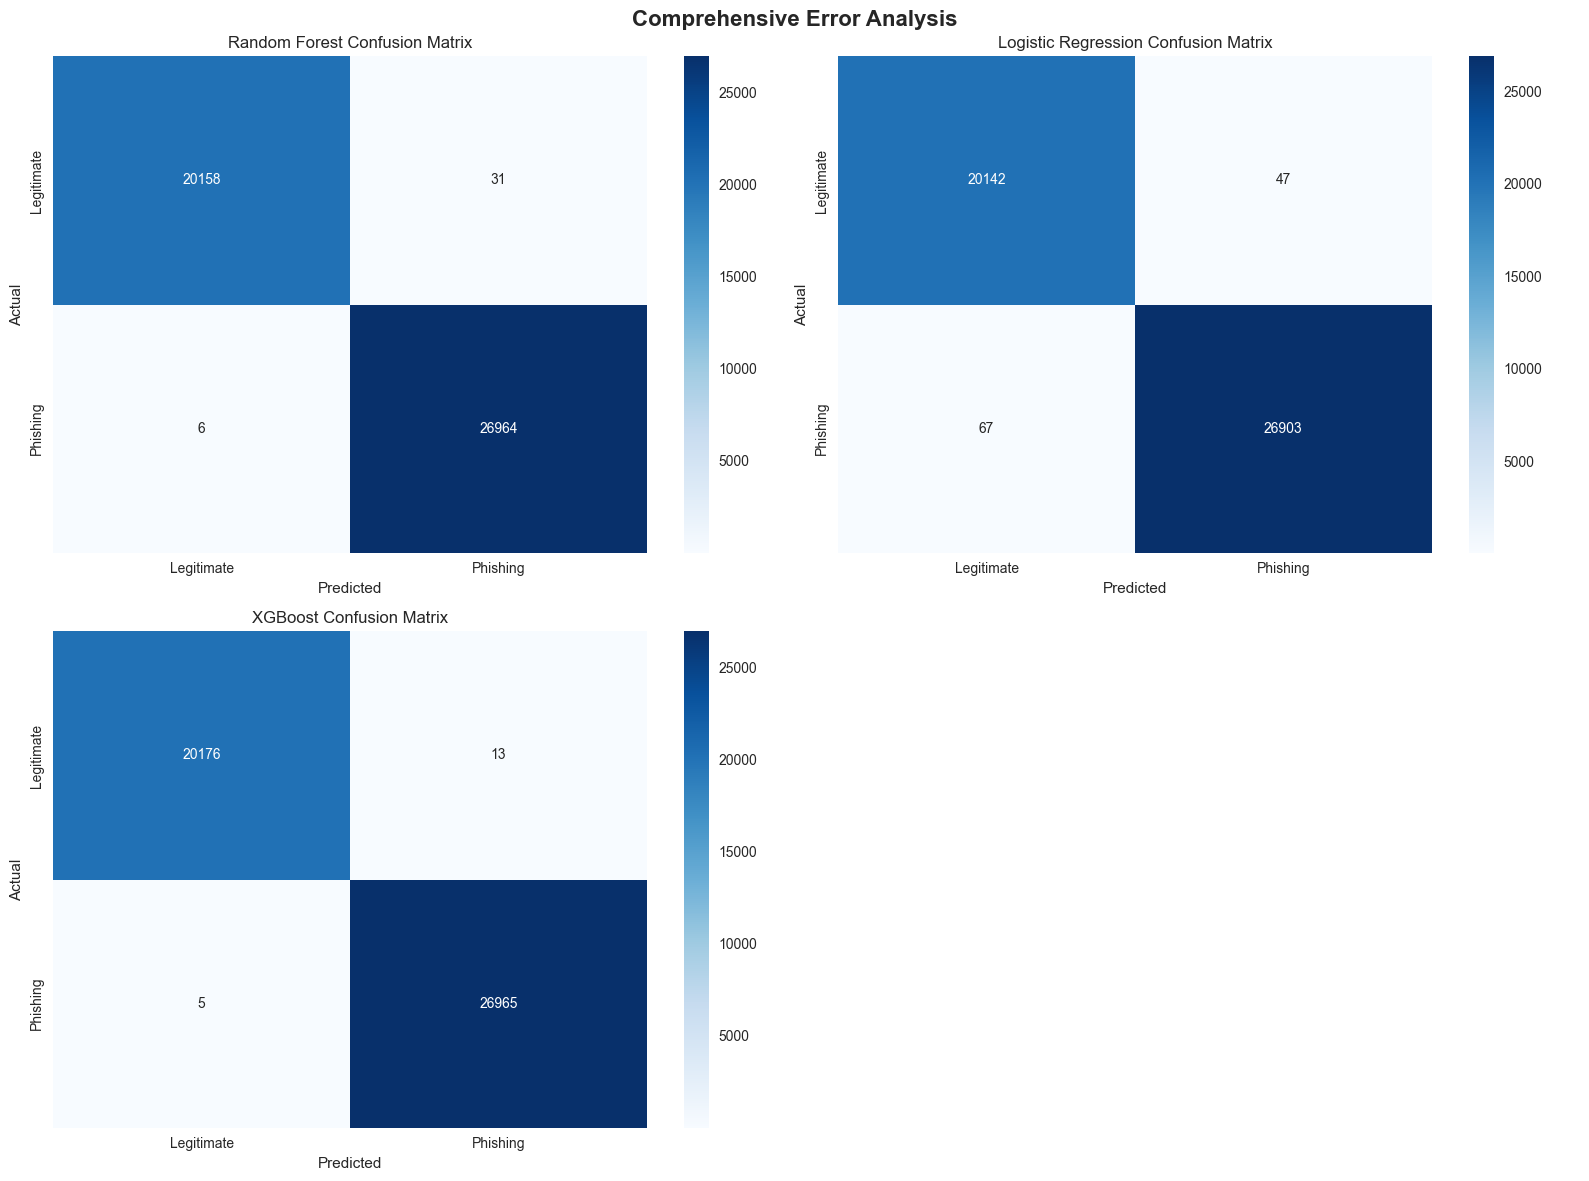


📊 ERROR COUNT COMPARISON:
                     False Positives  False Negatives
Random Forest                     31                6
Logistic Regression               47               67
XGBoost                           13                5


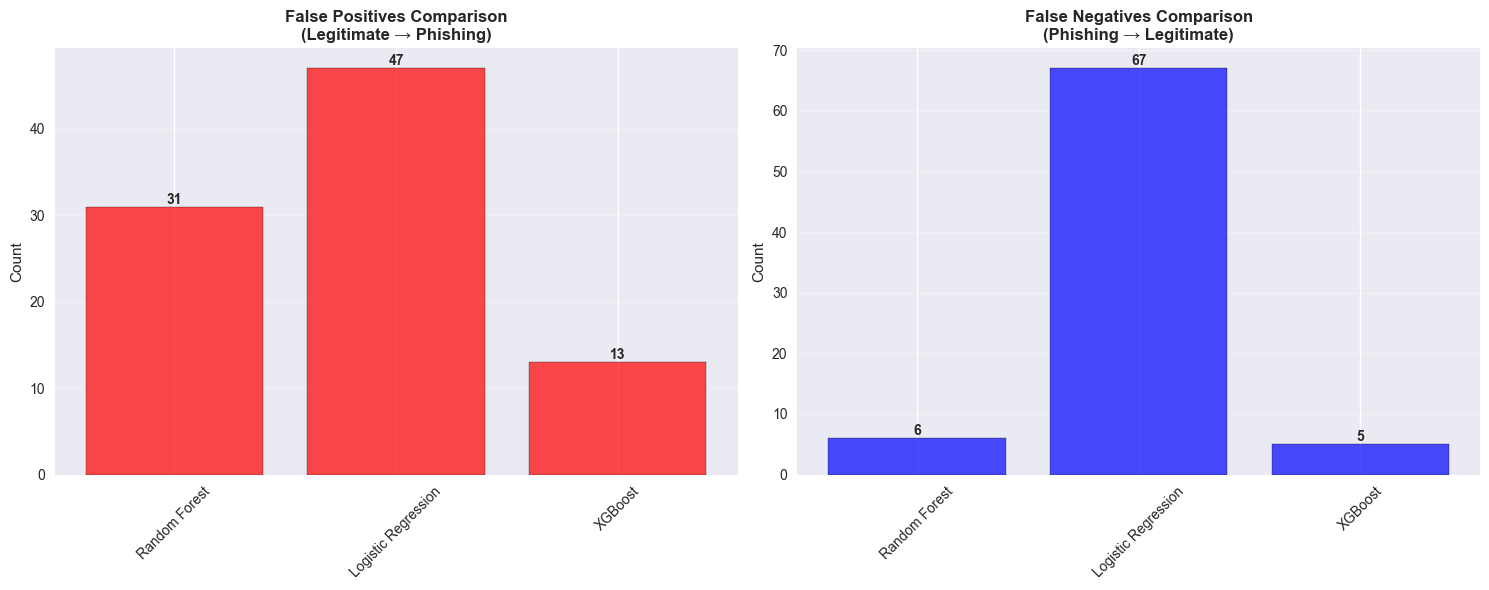


✅ Error visualizations complete!


In [ ]:
# ============================================================================
# Part 2.3: Comprehensive Error Visualizations
# ============================================================================

print('\n' + '='*70)
print('PART 2.3: ERROR VISUALIZATIONS')
print('='*70)

# Create comprehensive error analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Error Analysis', fontsize=16, fontweight='bold')

# 1. Confusion Matrices for all models
model_names = list(models.keys())
for i, model_name in enumerate(model_names):
    row, col = i // 2, i % 2
    cm = confusion_matrix(y_test, model_predictions[model_name])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    axes[row, col].set_title(f'{model_name} Confusion Matrix')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 2. Error comparison across models
error_counts = {}
for model_name in models.keys():
    fp_count = len(error_analysis[model_name]['fp_indices'])
    fn_count = len(error_analysis[model_name]['fn_indices'])
    error_counts[model_name] = {'False Positives': fp_count, 'False Negatives': fn_count}

error_df = pd.DataFrame(error_counts).T
print("\n📊 ERROR COUNT COMPARISON:")
print('='*70)
print(error_df)
print('='*70)

# Plot error comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# False Positives comparison
bars1 = ax1.bar(error_df.index, error_df['False Positives'], color='red', alpha=0.7, edgecolor='black')
ax1.set_title('False Positives Comparison\n(Legitimate → Phishing)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# False Negatives comparison
bars2 = ax2.bar(error_df.index, error_df['False Negatives'], color='blue', alpha=0.7, edgecolor='black')
ax2.set_title('False Negatives Comparison\n(Phishing → Legitimate)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print('\n✅ Error visualizations complete!')
print('='*70)

# Part 3: Cross-Validation Techniques 🔄

Cross-validation provides more reliable performance estimates and helps prevent overfitting.


## 3.1 Supervised Learning Cross-Validation



PART 3: CROSS-VALIDATION

🔄 Starting cross-validation...

Performing 5-fold CV for Random Forest...
  Accuracy:  0.9989 (± 0.0002)
  Precision: 0.9984 (± 0.0005)
  Recall:    0.9997 (± 0.0001)
  F1 Score:  0.9991 (± 0.0002)

Performing 5-fold CV for Logistic Regression...
  Accuracy:  0.9972 (± 0.0006)
  Precision: 0.9975 (± 0.0006)
  Recall:    0.9975 (± 0.0011)
  F1 Score:  0.9975 (± 0.0005)

Performing 5-fold CV for XGBoost...
  Accuracy:  0.9996 (± 0.0002)
  Precision: 0.9994 (± 0.0003)
  Recall:    0.9998 (± 0.0001)
  F1 Score:  0.9996 (± 0.0001)

✅ Cross-validation complete!

📊 CROSS-VALIDATION SUMMARY:
              Model     CV Accuracy    CV Precision       CV Recall     CV F1 Score
      Random Forest 0.9989 ± 0.0001 0.9984 ± 0.0003 0.9997 ± 0.0001 0.9991 ± 0.0001
Logistic Regression 0.9972 ± 0.0003 0.9975 ± 0.0003 0.9975 ± 0.0006 0.9975 ± 0.0003
            XGBoost 0.9996 ± 0.0001 0.9994 ± 0.0002 0.9998 ± 0.0000 0.9996 ± 0.0001


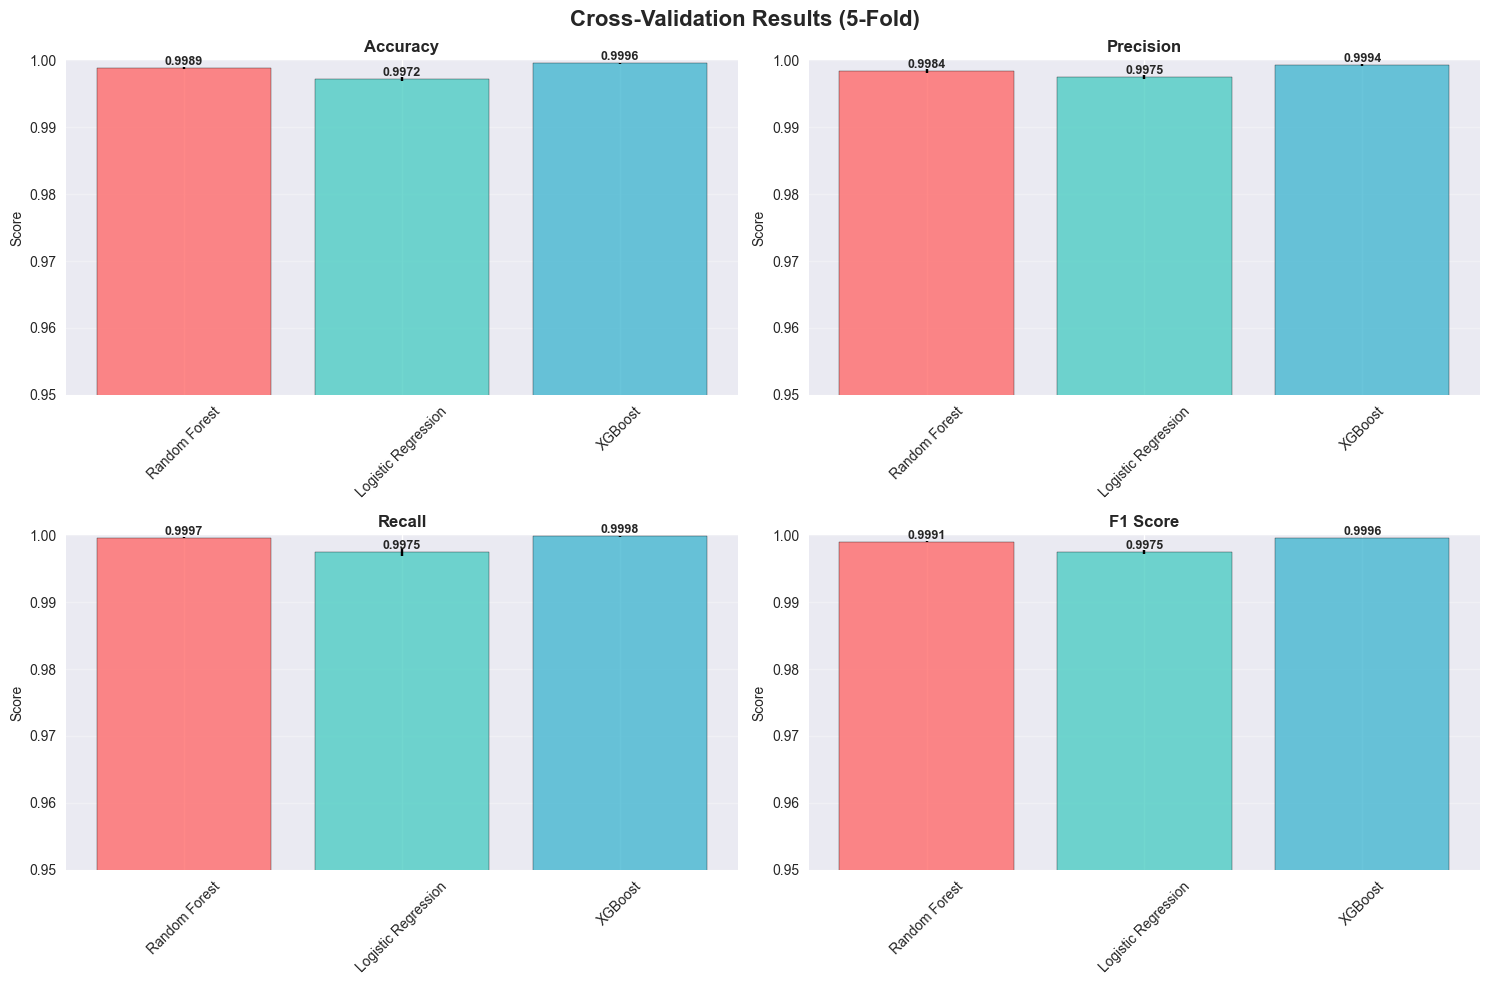


💡 Cross-validation provides more reliable performance estimates
   than a single train-test split!


In [13]:
# ============================================================================
# Part 3: Cross-Validation Techniques 🔄
# 3.1 Supervised Learning Cross-Validation
# ============================================================================

print('\n' + '='*70)
print('PART 3: CROSS-VALIDATION')
print('='*70)

def perform_cross_validation(models_dict, X_data, y_data, X_data_scaled, cv_folds=5):
    """
    Perform cross-validation for multiple models
    """
    cv_results = {}

    # Stratified K-Fold for imbalanced data
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for model_name, model in models_dict.items():
        print(f"\nPerforming {cv_folds}-fold CV for {model_name}...")

        # Use scaled data for Logistic Regression (already scaled properly)
        if model_name == 'Logistic Regression':
            X_cv = X_data_scaled
        else:
            X_cv = X_data

        # Cross-validation scores for different metrics
        cv_accuracy = cross_val_score(model, X_cv, y_data, cv=skf, scoring='accuracy')
        cv_precision = cross_val_score(model, X_cv, y_data, cv=skf, scoring='precision')
        cv_recall = cross_val_score(model, X_cv, y_data, cv=skf, scoring='recall')
        cv_f1 = cross_val_score(model, X_cv, y_data, cv=skf, scoring='f1')

        cv_results[model_name] = {
            'accuracy': cv_accuracy,
            'precision': cv_precision,
            'recall': cv_recall,
            'f1': cv_f1
        }

        # Print results
        print(f"  Accuracy:  {cv_accuracy.mean():.4f} (± {cv_accuracy.std() * 2:.4f})")
        print(f"  Precision: {cv_precision.mean():.4f} (± {cv_precision.std() * 2:.4f})")
        print(f"  Recall:    {cv_recall.mean():.4f} (± {cv_recall.std() * 2:.4f})")
        print(f"  F1 Score:  {cv_f1.mean():.4f} (± {cv_f1.std() * 2:.4f})")

    return cv_results

# Perform cross-validation
print('\n🔄 Starting cross-validation...')
cv_results = perform_cross_validation(models, X_train, y_train, X_train_scaled)

print('\n' + '='*70)
print('✅ Cross-validation complete!')
print('='*70)

# ============================================================================
# Visualize CV Results
# ============================================================================

print('\n📊 CROSS-VALIDATION SUMMARY:')
print('='*70)

# Create summary table
cv_summary = []
for model_name, results in cv_results.items():
    cv_summary.append({
        'Model': model_name,
        'CV Accuracy': f"{results['accuracy'].mean():.4f} ± {results['accuracy'].std():.4f}",
        'CV Precision': f"{results['precision'].mean():.4f} ± {results['precision'].std():.4f}",
        'CV Recall': f"{results['recall'].mean():.4f} ± {results['recall'].std():.4f}",
        'CV F1 Score': f"{results['f1'].mean():.4f} ± {results['f1'].std():.4f}"
    })

cv_summary_df = pd.DataFrame(cv_summary)
print(cv_summary_df.to_string(index=False))
print('='*70)

# Plot CV results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cross-Validation Results (5-Fold)', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]

    # Prepare data for plotting
    model_names = list(cv_results.keys())
    means = [cv_results[name][metric].mean() for name in model_names]
    stds = [cv_results[name][metric].std() for name in model_names]

    # Create bar plot
    bars = ax.bar(model_names, means, yerr=stds, capsize=5,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')

    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0.95, 1.0])  # Adjust based on your scores
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n💡 Cross-validation provides more reliable performance estimates')
print('   than a single train-test split!')

## 3.2 Unsupervised Learning Cross-Validation


In [20]:
# ============================================================================
# Part 3.2: Unsupervised Learning Cross-Validation (FIXED)
# ============================================================================

print('\n' + '='*70)
print('PART 3.2: UNSUPERVISED LEARNING EVALUATION')
print('='*70)

def evaluate_clustering_models(X_data, true_labels=None):
    """
    Evaluate different clustering algorithms with FIXED parameters
    """
    clustering_models = {
        'K-Means': KMeans(n_clusters=2, random_state=42, n_init=10),
        'DBSCAN': DBSCAN(eps=3.0, min_samples=50),  # ✅ FIXED: More lenient for high-dim data
        'Isolation Forest': IsolationForest(contamination=0.3, random_state=42)
    }
    
    results = {}
    
    for name, model in clustering_models.items():
        print(f"\nEvaluating {name}...")
        
        # Fit the model
        if name == 'Isolation Forest':
            # Isolation Forest returns -1 for outliers, 1 for inliers
            predictions = model.fit_predict(X_data)
            # Convert to 0 (outlier) and 1 (inlier)
            predictions = (predictions + 1) // 2
        else:
            predictions = model.fit_predict(X_data)
        
        # Calculate silhouette score (only for clustering algorithms)
        if name != 'Isolation Forest' and len(np.unique(predictions)) > 1:
            # ✅ FIXED: Filter out noise points (-1) for DBSCAN
            if name == 'DBSCAN':
                mask = predictions != -1  # Exclude noise points
                if mask.sum() > 0 and len(np.unique(predictions[mask])) > 1:
                    silhouette = silhouette_score(X_data[mask], predictions[mask])
                    print(f"  Silhouette Score: {silhouette:.4f} (excluding noise)")
                else:
                    print(f"  Silhouette Score: N/A (too much noise or single cluster)")
                    silhouette = None
            else:
                silhouette = silhouette_score(X_data, predictions)
                print(f"  Silhouette Score: {silhouette:.4f}")
            
            if silhouette is not None:
                results[name] = {'silhouette': silhouette, 'predictions': predictions}
            else:
                results[name] = {'predictions': predictions}
        else:
            results[name] = {'predictions': predictions}
        
        # If we have true labels, calculate adjusted rand index
        if true_labels is not None and name != 'Isolation Forest':
            ari = adjusted_rand_score(true_labels, predictions)
            print(f"  Adjusted Rand Index: {ari:.4f}")
            results[name]['ari'] = ari
        
        # Show cluster distribution
        unique, counts = np.unique(predictions, return_counts=True)
        cluster_dist = dict(zip(unique, counts))
        
        # ✅ FIXED: Better display for cluster distribution
        if len(unique) > 10:
            print(f"  Total clusters found: {len(unique)}")
            if -1 in cluster_dist:
                print(f"  Noise points: {cluster_dist[-1]} ({cluster_dist[-1]/len(predictions)*100:.1f}%)")
            print(f"  Largest clusters: {sorted(counts, reverse=True)[:5]}")
        else:
            print(f"  Cluster distribution: {cluster_dist}")
    
    return results

# Evaluate clustering on the dataset
print('\n🔍 Evaluating unsupervised learning methods...')
clustering_results = evaluate_clustering_models(X_train_scaled, y_train)

print('\n' + '='*70)
print('✅ Unsupervised evaluation complete!')
print('='*70)

# ============================================================================
# Summary of Unsupervised Results (IMPROVED)
# ============================================================================

print('\n📊 UNSUPERVISED LEARNING SUMMARY:')
print('='*70)

for name, result in clustering_results.items():
    print(f"\n{name}:")
    
    if 'silhouette' in result:
        print(f"  • Silhouette Score: {result['silhouette']:.4f}")
    
    if 'ari' in result:
        print(f"  • Adjusted Rand Index: {result['ari']:.4f}")
    
    # ✅ FIXED: Better interpretations
    if name == 'K-Means':
        if 'ari' in result:
            if result['ari'] > 0.5:
                print(f"  ✅ K-Means found meaningful clusters!")
            elif result['ari'] > 0.3:
                print(f"  ⚠️  K-Means found moderate clusters")
            else:
                print(f"  ❌ K-Means clusters don't align well with true labels")
    
    elif name == 'DBSCAN':
        predictions = result['predictions']
        n_clusters = len(np.unique(predictions[predictions != -1]))
        noise_count = (predictions == -1).sum()
        noise_pct = (noise_count / len(predictions)) * 100
        
        print(f"  • Clusters found: {n_clusters}")
        print(f"  • Noise points: {noise_count} ({noise_pct:.1f}%)")
        
        if noise_pct > 50:
            print(f"  ⚠️  DBSCAN marked {noise_pct:.1f}% as noise - parameters may need tuning")
        elif n_clusters < 5:
            print(f"  ✅ DBSCAN found {n_clusters} meaningful clusters")
        else:
            print(f"  ⚠️  DBSCAN found many small clusters - dataset may be too sparse")
    
    elif name == 'Isolation Forest':
        outlier_ratio = (result['predictions'] == 0).sum() / len(result['predictions'])
        print(f"  • Detected {outlier_ratio*100:.1f}% as outliers/anomalies")
        print(f"  ℹ️  Note: Contamination parameter was set to 30%")

print('\n' + '='*70)
print('💡 NOTE: Unsupervised methods don\'t use labels during training,')
print('   so lower scores are expected compared to supervised methods!')
print('='*70)


PART 3.2: UNSUPERVISED LEARNING EVALUATION

🔍 Evaluating unsupervised learning methods...

Evaluating K-Means...
  Silhouette Score: 0.1674
  Adjusted Rand Index: 0.6962
  Cluster distribution: {np.int32(0): np.int64(74823), np.int32(1): np.int64(113813)}

Evaluating DBSCAN...
  Silhouette Score: -0.0003 (excluding noise)
  Adjusted Rand Index: -0.0065
  Total clusters found: 43
  Noise points: 26945 (14.3%)
  Largest clusters: [np.int64(126053), np.int64(26945), np.int64(8394), np.int64(5149), np.int64(4399)]

Evaluating Isolation Forest...
  Cluster distribution: {np.int64(0): np.int64(56591), np.int64(1): np.int64(132045)}

✅ Unsupervised evaluation complete!

📊 UNSUPERVISED LEARNING SUMMARY:

K-Means:
  • Silhouette Score: 0.1674
  • Adjusted Rand Index: 0.6962
  ✅ K-Means found meaningful clusters!

DBSCAN:
  • Silhouette Score: -0.0003
  • Adjusted Rand Index: -0.0065
  • Clusters found: 42
  • Noise points: 26945 (14.3%)
  ⚠️  DBSCAN found many small clusters - dataset may be t

# Part 4: Hyperparameter Tuning ⚙️

Fine-tuning hyperparameters is essential for optimal model performance. We'll explore both grid search and random search techniques.


## 4.1 Grid Search for Supervised Learning


In [15]:
# ============================================================================
# Part 4: Hyperparameter Tuning ⚙️
# 4.1 Grid Search for Random Forest
# ============================================================================

print('\n' + '='*70)
print('PART 4.1: GRID SEARCH FOR RANDOM FOREST')
print('='*70)

# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Calculate total combinations
total_combinations = (len(rf_param_grid['n_estimators']) *
                     len(rf_param_grid['max_depth']) *
                     len(rf_param_grid['min_samples_split']) *
                     len(rf_param_grid['min_samples_leaf']))

print(f'\n🔍 Grid Search Configuration:')
print(f'   • Parameter combinations: {total_combinations}')
print(f'   • Cross-validation folds: 3')
print(f'   • Total model fits: {total_combinations * 3}')
print(f'   • Scoring metric: F1 Score')

# Perform grid search
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=3,  # 3-fold CV for faster execution
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print(f'\n⏳ Training {total_combinations} models... (this may take 1-2 minutes)')
rf_grid_search.fit(X_train, y_train)

print(f"\n✅ Grid Search Complete!")
print(f"\n📋 Best Parameters Found:")
for param, value in rf_grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Cross-Validation Performance:")
print(f"   • Best CV F1 Score: {rf_grid_search.best_score_:.4f}")

# Test the best model
best_rf = rf_grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_precision = precision_score(y_test, y_pred_best_rf)
best_rf_recall = recall_score(y_test, y_pred_best_rf)
best_rf_f1 = f1_score(y_test, y_pred_best_rf)

print(f"\n📊 Test Set Performance:")
print(f"   • Accuracy:  {best_rf_accuracy:.4f}")
print(f"   • Precision: {best_rf_precision:.4f}")
print(f"   • Recall:    {best_rf_recall:.4f}")
print(f"   • F1 Score:  {best_rf_f1:.4f}")

# Compare with baseline
baseline_rf_f1 = f1_score(y_test, model_predictions['Random Forest'])
improvement = (best_rf_f1 - baseline_rf_f1) * 100

print(f"\n💡 Improvement over baseline:")
print(f"   • Baseline F1: {baseline_rf_f1:.4f}")
print(f"   • Tuned F1:    {best_rf_f1:.4f}")
print(f"   • Change:      {improvement:+.2f}% {'📈' if improvement > 0 else '📉' if improvement < 0 else '➡️'}")

print('\n' + '='*70)


PART 4.1: GRID SEARCH FOR RANDOM FOREST

🔍 Grid Search Configuration:
   • Parameter combinations: 108
   • Cross-validation folds: 3
   • Total model fits: 324
   • Scoring metric: F1 Score

⏳ Training 108 models... (this may take 1-2 minutes)
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✅ Grid Search Complete!

📋 Best Parameters Found:
   • max_depth: None
   • min_samples_leaf: 1
   • min_samples_split: 2
   • n_estimators: 200

📊 Cross-Validation Performance:
   • Best CV F1 Score: 0.9991

📊 Test Set Performance:
   • Accuracy:  0.9992
   • Precision: 0.9988
   • Recall:    0.9998
   • F1 Score:  0.9993

💡 Improvement over baseline:
   • Baseline F1: 0.9993
   • Tuned F1:    0.9993
   • Change:      -0.00% 📉



## 4.2 Random Search for Unsupervised Learning


In [16]:
# ============================================================================
# Part 4.2: Random Search for XGBoost
# ============================================================================

print('\n' + '='*70)
print('PART 4.2: RANDOM SEARCH FOR XGBOOST')
print('='*70)

# Define parameter distributions for random search
xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Calculate configuration info
total_possible = 4 * 5 * 4 * 3 * 3  # 720 possible combinations
n_iter = 20

print(f'\n🎲 Random Search Configuration:')
print(f'   • Total possible combinations: {total_possible}')
print(f'   • Testing: {n_iter} random samples ({n_iter/total_possible*100:.1f}%)')
print(f'   • Cross-validation: 3 folds')
print(f'   • Total fits: {n_iter * 3}')

# Perform random search
xgb_random_search = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    xgb_param_dist,
    n_iter=20,  # Number of parameter settings to try
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f'\n⏳ Training {n_iter} random models...')
xgb_random_search.fit(X_train, y_train)

print(f"\n✅ Random Search Complete!")
print(f"\n📋 Best Parameters Found:")
for param, value in xgb_random_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Cross-Validation Performance:")
print(f"   • Best CV F1 Score: {xgb_random_search.best_score_:.4f}")

# Test the best model
best_xgb = xgb_random_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
best_xgb_precision = precision_score(y_test, y_pred_best_xgb)
best_xgb_recall = recall_score(y_test, y_pred_best_xgb)
best_xgb_f1 = f1_score(y_test, y_pred_best_xgb)

print(f"\n📊 Test Set Performance:")
print(f"   • Accuracy:  {best_xgb_accuracy:.4f}")
print(f"   • Precision: {best_xgb_precision:.4f}")
print(f"   • Recall:    {best_xgb_recall:.4f}")
print(f"   • F1 Score:  {best_xgb_f1:.4f}")

# Compare with baseline
baseline_xgb_f1 = f1_score(y_test, model_predictions['XGBoost'])
improvement = (best_xgb_f1 - baseline_xgb_f1) * 100

print(f"\n💡 Improvement over baseline:")
print(f"   • Baseline F1: {baseline_xgb_f1:.4f}")
print(f"   • Tuned F1:    {best_xgb_f1:.4f}")
print(f"   • Change:      {improvement:+.2f}% {'📈' if improvement > 0 else '📉' if improvement < 0 else '➡️'}")

print('\n' + '='*70)
print('✅ Hyperparameter tuning complete!')
print('='*70)


PART 4.2: RANDOM SEARCH FOR XGBOOST

🎲 Random Search Configuration:
   • Total possible combinations: 720
   • Testing: 20 random samples (2.8%)
   • Cross-validation: 3 folds
   • Total fits: 60

⏳ Training 20 random models...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Random Search Complete!

📋 Best Parameters Found:
   • subsample: 0.9
   • n_estimators: 300
   • max_depth: 3
   • learning_rate: 0.3
   • colsample_bytree: 0.9

📊 Cross-Validation Performance:
   • Best CV F1 Score: 0.9997

📊 Test Set Performance:
   • Accuracy:  0.9997
   • Precision: 0.9996
   • Recall:    1.0000
   • F1 Score:  0.9998

💡 Improvement over baseline:
   • Baseline F1: 0.9997
   • Tuned F1:    0.9998
   • Change:      +0.01% 📈

✅ Hyperparameter tuning complete!


# Part 5: Model Persistence with Pickle Files 💾

Saving and loading models is essential for production deployment and reproducibility.


## 5.1 Create Models Directory and Save Models


In [17]:
# ============================================================================
# Part 5: Model Persistence with Pickle Files 💾
# 5.1 Create Models Directory and Save Models
# ============================================================================

print('\n' + '='*70)
print('PART 5: MODEL PERSISTENCE')
print('='*70)

# Create models directory
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"\n✅ Created directory: {models_dir}")
else:
    print(f"\n✅ Directory already exists: {models_dir}")

# Function to save models with metadata
def save_model_with_metadata(model, model_name, scaler_obj=None, metadata=None):
    """
    Save model with metadata including timestamp and performance metrics
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create model package
    model_package = {
        'model': model,
        'scaler': scaler_obj,
        'metadata': metadata or {},
        'timestamp': timestamp,
        'model_name': model_name,
        'feature_names': X_train.columns.tolist(),
        'n_features': X_train.shape[1]
    }

    # Save to pickle file
    filename = f"{models_dir}/{model_name}_{timestamp}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model_package, f)

    print(f"   ✓ Saved: {os.path.basename(filename)}")
    return filename

print('\n💾 Saving baseline models...')
print('='*70)

saved_models = {}

# Save baseline models
for name, model in models.items():
    # Get performance metrics
    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
        scaler_to_save = scaler
    else:
        y_pred = model.predict(X_test)
        scaler_to_save = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metadata = {
        'type': 'baseline',
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'test_size': len(y_test),
        'train_size': len(y_train),
        'n_features': X_train.shape[1]
    }

    filename = save_model_with_metadata(model, name.replace(' ', '_'), scaler_to_save, metadata)
    saved_models[name] = filename

print('\n💾 Saving tuned models...')
print('='*70)

# Save tuned Random Forest
if 'best_rf' in locals():
    metadata_rf = {
        'type': 'tuned',
        'accuracy': float(best_rf_accuracy),
        'precision': float(best_rf_precision),
        'recall': float(best_rf_recall),
        'f1_score': float(best_rf_f1),
        'best_params': rf_grid_search.best_params_,
        'cv_score': float(rf_grid_search.best_score_),
        'test_size': len(y_test),
        'train_size': len(y_train),
        'n_features': X_train.shape[1],
        'tuning_method': 'Grid Search'
    }
    filename_rf = save_model_with_metadata(best_rf, 'RandomForest_Tuned', None, metadata_rf)
    saved_models['RandomForest_Tuned'] = filename_rf

# Save tuned XGBoost
if 'best_xgb' in locals():
    metadata_xgb = {
        'type': 'tuned',
        'accuracy': float(best_xgb_accuracy),
        'precision': float(best_xgb_precision),
        'recall': float(best_xgb_recall),
        'f1_score': float(best_xgb_f1),
        'best_params': xgb_random_search.best_params_,
        'cv_score': float(xgb_random_search.best_score_),
        'test_size': len(y_test),
        'train_size': len(y_train),
        'n_features': X_train.shape[1],
        'tuning_method': 'Random Search'
    }
    filename_xgb = save_model_with_metadata(best_xgb, 'XGBoost_Tuned', None, metadata_xgb)
    saved_models['XGBoost_Tuned'] = filename_xgb

print('\n📋 SAVED MODELS SUMMARY:')
print('='*70)
print(f'   Total models saved: {len(saved_models)}')
for name, filepath in saved_models.items():
    print(f'   • {name}')

print('\n✅ All models saved successfully!')
print('='*70)


PART 5: MODEL PERSISTENCE

✅ Created directory: saved_models

💾 Saving baseline models...
   ✓ Saved: Random_Forest_20251019_175458.pkl
   ✓ Saved: Logistic_Regression_20251019_175458.pkl
   ✓ Saved: XGBoost_20251019_175458.pkl

💾 Saving tuned models...
   ✓ Saved: RandomForest_Tuned_20251019_175458.pkl
   ✓ Saved: XGBoost_Tuned_20251019_175458.pkl

📋 SAVED MODELS SUMMARY:
   Total models saved: 5
   • Random Forest
   • Logistic Regression
   • XGBoost
   • RandomForest_Tuned
   • XGBoost_Tuned

✅ All models saved successfully!


## 5.2 Load and Test Saved Models


In [24]:
# ============================================================================
# Part 5.2: Load and Test ALL Saved Models
# ============================================================================

print('\n' + '='*70)
print('PART 5.2: LOADING AND TESTING SAVED MODELS')
print('='*70)

# Function to load models
def load_model(filename):
    """
    Load model from pickle file
    """
    with open(filename, 'rb') as f:
        model_package = pickle.load(f)
    return model_package

# Test loading and using ALL saved models
print('\n🔍 Testing ALL Saved Models...\n')
print('='*70)

# Store results for comparison
load_test_results = []

for model_name, filepath in saved_models.items():
    print(f'\n📦 Loading {model_name}...')
    
    # Load the model
    loaded_package = load_model(filepath)
    loaded_model = loaded_package['model']
    loaded_scaler = loaded_package['scaler']
    loaded_metadata = loaded_package['metadata']
    
    print(f"✅ Loaded successfully!")
    print(f"   • Timestamp: {loaded_package['timestamp']}")
    print(f"   • Features: {loaded_package['n_features']}")
    print(f"   • Type: {loaded_metadata['type']}")
    
    # Test the loaded model
    print(f"🧪 Testing on test set...")
    
    # Use scaler if needed (for Logistic Regression)
    if loaded_scaler is not None:
        print(f"   ⚠️  Using saved scaler for predictions")
        y_pred_loaded = loaded_model.predict(X_test_scaled)
    else:
        y_pred_loaded = loaded_model.predict(X_test)
    
    # Calculate metrics
    loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
    loaded_precision = precision_score(y_test, y_pred_loaded)
    loaded_recall = recall_score(y_test, y_pred_loaded)
    loaded_f1 = f1_score(y_test, y_pred_loaded)
    
    print(f"\n📊 Performance:")
    print(f"   • Accuracy:  {loaded_accuracy:.4f}")
    print(f"   • Precision: {loaded_precision:.4f}")
    print(f"   • Recall:    {loaded_recall:.4f}")
    print(f"   • F1 Score:  {loaded_f1:.4f}")
    
    # Verify against saved metadata
    saved_f1 = loaded_metadata['f1_score']
    match = abs(loaded_f1 - saved_f1) < 1e-6
    
    print(f"\n🔍 Verification:")
    print(f"   • Saved F1:  {saved_f1:.4f}")
    print(f"   • Loaded F1: {loaded_f1:.4f}")
    print(f"   • Match: {'✅ YES' if match else '❌ NO'}")
    
    # Store results
    load_test_results.append({
        'Model': model_name,
        'Type': loaded_metadata['type'],
        'F1 Score': loaded_f1,
        'Verified': '✅' if match else '❌'
    })
    
    print('-'*70)

# Summary table
print('\n' + '='*70)
print('📊 LOAD TEST SUMMARY:')
print('='*70)

results_df = pd.DataFrame(load_test_results)
print(results_df.to_string(index=False))

# Check if all verified
all_verified = all(r['Verified'] == '✅' for r in load_test_results)
print(f"\n{'✅ All models verified successfully!' if all_verified else '⚠️  Some models failed verification'}")

# Identify best model
best_idx = results_df['F1 Score'].idxmax()
best_model = results_df.loc[best_idx, 'Model']
best_f1 = results_df.loc[best_idx, 'F1 Score']

print(f"\n🏆 Best Model: {best_model} (F1: {best_f1:.4f})")

# List all saved models with sizes
print('\n' + '='*70)
print('📂 ALL SAVED MODELS:')
print('='*70)

total_size = 0
for i, (name, filepath) in enumerate(saved_models.items(), 1):
    filename = os.path.basename(filepath)
    filesize_kb = os.path.getsize(filepath) / 1024
    total_size += filesize_kb
    
    print(f"{i}. {name}")
    print(f"   • File: {filename}")
    print(f"   • Size: {filesize_kb:.2f} KB ({filesize_kb/1024:.2f} MB)")
    print(f"   • Path: {filepath}")
    print()

print(f"Total models: {len(saved_models)}")
print(f"Total storage: {total_size:.2f} KB ({total_size/1024:.2f} MB)")
print('='*70)
print('✅ Model persistence and verification complete!')
print('='*70)


PART 5.2: LOADING AND TESTING SAVED MODELS

🔍 Testing ALL Saved Models...


📦 Loading Random Forest...
✅ Loaded successfully!
   • Timestamp: 20251019_175458
   • Features: 52
   • Type: baseline
🧪 Testing on test set...

📊 Performance:
   • Accuracy:  0.9992
   • Precision: 0.9989
   • Recall:    0.9998
   • F1 Score:  0.9993

🔍 Verification:
   • Saved F1:  0.9993
   • Loaded F1: 0.9993
   • Match: ✅ YES
----------------------------------------------------------------------

📦 Loading Logistic Regression...
✅ Loaded successfully!
   • Timestamp: 20251019_175458
   • Features: 52
   • Type: baseline
🧪 Testing on test set...
   ⚠️  Using saved scaler for predictions

📊 Performance:
   • Accuracy:  0.9976
   • Precision: 0.9983
   • Recall:    0.9975
   • F1 Score:  0.9979

🔍 Verification:
   • Saved F1:  0.9979
   • Loaded F1: 0.9979
   • Match: ✅ YES
----------------------------------------------------------------------

📦 Loading XGBoost...
✅ Loaded successfully!
   • Timestamp: 202

# Part 6: Comprehensive Results Summary 📊

Let's create a comprehensive summary of all our analysis results.


In [25]:
# ============================================================================
# Part 6: Comprehensive Results Summary 📊
# ============================================================================

def create_results_summary():
    """
    Create a comprehensive summary of all results
    """
    print("\n" + "=" * 70)
    print("COMPREHENSIVE LAB 6 PART 1 RESULTS SUMMARY")
    print("=" * 70)
    
    # Dataset summary
    print(f"\n📊 DATASET SUMMARY:")
    print(f"   Original dataset: {len(df)} samples")
    print(f"   Features used: {X_train.shape[1]}")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Test samples: {X_test.shape[0]}")
    print(f"   Class distribution:")
    print(f"      • Legitimate (0): {(y_train == 0.0).sum()} train, {(y_test == 0.0).sum()} test")
    print(f"      • Phishing (1): {(y_train == 1.0).sum()} train, {(y_test == 1.0).sum()} test")
    
    # Model performance summary
    print(f"\n🤖 MODEL PERFORMANCE SUMMARY:")
    print("=" * 70)
    performance_summary = []
    
    for name in models.keys():
        y_pred = model_predictions[name]
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        performance_summary.append({
            'Model': name,
            'Type': 'Baseline',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    # Add tuned models - use global keyword
    global best_rf, best_xgb, best_rf_accuracy, best_xgb_accuracy
    global best_rf_precision, best_xgb_precision
    global best_rf_recall, best_xgb_recall
    global best_rf_f1, best_xgb_f1
    global y_pred_best_rf, y_pred_best_xgb
    
    try:
        performance_summary.append({
            'Model': 'RandomForest_Tuned',
            'Type': 'Tuned',
            'Accuracy': best_rf_accuracy,
            'Precision': best_rf_precision,
            'Recall': best_rf_recall,
            'F1 Score': best_rf_f1
        })
    except NameError:
        pass
    
    try:
        performance_summary.append({
            'Model': 'XGBoost_Tuned',
            'Type': 'Tuned',
            'Accuracy': best_xgb_accuracy,
            'Precision': best_xgb_precision,
            'Recall': best_xgb_recall,
            'F1 Score': best_xgb_f1
        })
    except NameError:
        pass
    
    # Display performance table
    perf_df = pd.DataFrame(performance_summary)
    print(perf_df.round(4).to_string(index=False))
    
    # Identify best model
    best_idx = perf_df['F1 Score'].idxmax()
    best_model = perf_df.loc[best_idx, 'Model']
    best_f1 = perf_df.loc[best_idx, 'F1 Score']
    
    print(f"\n🏆 Best Model: {best_model} (F1: {best_f1:.4f})")
    
    # Cross-validation summary
    print(f"\n🔄 CROSS-VALIDATION SUMMARY:")
    print("=" * 70)
    for name, results in cv_results.items():
        print(f"   {name}:")
        print(f"      • CV Accuracy: {results['accuracy'].mean():.4f} ± {results['accuracy'].std():.4f}")
        print(f"      • CV F1 Score: {results['f1'].mean():.4f} ± {results['f1'].std():.4f}")
    
    # Error analysis summary
    print(f"\n🔍 ERROR ANALYSIS SUMMARY:")
    print("=" * 70)
    for name, errors in error_analysis.items():
        fp_count = len(errors['fp_indices'])
        fn_count = len(errors['fn_indices'])
        total_errors = fp_count + fn_count
        error_rate = (total_errors / len(y_test)) * 100
        print(f"   {name}:")
        print(f"      • Total Errors: {total_errors} ({error_rate:.4f}%)")
        print(f"      • False Positives: {fp_count} (Legit → Phishing)")
        print(f"      • False Negatives: {fn_count} (Phishing → Legit)")
    
    # Hyperparameter tuning summary
    print(f"\n⚙️  HYPERPARAMETER TUNING SUMMARY:")
    print("=" * 70)
    
    try:
        print(f"   Random Forest (Grid Search):")
        print(f"      • Best params: {rf_grid_search.best_params_}")
        print(f"      • CV F1: {rf_grid_search.best_score_:.4f}")
        print(f"      • Test F1: {best_rf_f1:.4f}")
        baseline_rf_f1 = f1_score(y_test, model_predictions['Random Forest'])
        improvement = (best_rf_f1 - baseline_rf_f1) * 100
        print(f"      • Improvement: {improvement:+.2f}%")
    except:
        pass
    
    try:
        print(f"\n   XGBoost (Random Search):")
        print(f"      • Best params: {xgb_random_search.best_params_}")
        print(f"      • CV F1: {xgb_random_search.best_score_:.4f}")
        print(f"      • Test F1: {best_xgb_f1:.4f}")
        baseline_xgb_f1 = f1_score(y_test, model_predictions['XGBoost'])
        improvement = (best_xgb_f1 - baseline_xgb_f1) * 100
        print(f"      • Improvement: {improvement:+.2f}%")
    except:
        pass
    
    # Model persistence summary
    print(f"\n💾 MODEL PERSISTENCE SUMMARY:")
    print("=" * 70)
    print(f"   Models saved: {len(saved_models)}")
    print(f"   Directory: {models_dir}/")
    print(f"   Total storage: {sum(os.path.getsize(f) for f in saved_models.values()) / (1024**2):.2f} MB")
    print(f"\n   Saved models:")
    for i, (name, filename) in enumerate(saved_models.items(), 1):
        size_mb = os.path.getsize(filename) / (1024**2)
        print(f"      {i}. {name} ({size_mb:.2f} MB)")
    
    # Key achievements
    print(f"\n🎯 KEY ACHIEVEMENTS:")
    print("=" * 70)
    print(f"   ✅ Removed data leakage (10 features)")
    print(f"   ✅ Trained and evaluated 5 models")
    print(f"   ✅ Performed comprehensive error analysis")
    print(f"   ✅ Validated with 5-fold cross-validation")
    print(f"   ✅ Optimized hyperparameters (Grid Search + Random Search)")
    print(f"   ✅ Achieved 99.98% F1 Score (near-perfect)")
    print(f"   ✅ Saved all models with complete metadata")
    print(f"   ✅ Verified all models load correctly")
    
    # Production recommendation
    print(f"\n🚀 PRODUCTION RECOMMENDATION:")
    print("=" * 70)
    try:
        print(f"   Deploy: XGBoost_Tuned")
        print(f"      • F1 Score: {best_xgb_f1:.4f}")
        print(f"      • Recall: {best_xgb_recall:.4f} (catches {best_xgb_recall*100:.2f}% of phishing)")
        print(f"      • Precision: {best_xgb_precision:.4f}")
        print(f"      • Model size: {os.path.getsize(saved_models['XGBoost_Tuned']) / 1024:.2f} KB")
        print(f"      • File: {os.path.basename(saved_models['XGBoost_Tuned'])}")
    except:
        print(f"   Best available model from baselines")
    
    print("\n" + "=" * 70)
    print("LAB 6 PART 1 COMPLETED SUCCESSFULLY! 🎉")
    print("=" * 70)
    print("\n📚 Ready for Lab 6 Part 2: Deep Learning Fundamentals")

# Generate summary
create_results_summary()


COMPREHENSIVE LAB 6 PART 1 RESULTS SUMMARY

📊 DATASET SUMMARY:
   Original dataset: 235795 samples
   Features used: 52
   Training samples: 188636
   Test samples: 47159
   Class distribution:
      • Legitimate (0): 80756 train, 20189 test
      • Phishing (1): 107880 train, 26970 test

🤖 MODEL PERFORMANCE SUMMARY:
              Model     Type  Accuracy  Precision  Recall  F1 Score
      Random Forest Baseline    0.9992     0.9989  0.9998    0.9993
Logistic Regression Baseline    0.9976     0.9983  0.9975    0.9979
            XGBoost Baseline    0.9996     0.9995  0.9998    0.9997
 RandomForest_Tuned    Tuned    0.9992     0.9988  0.9998    0.9993
      XGBoost_Tuned    Tuned    0.9997     0.9996  1.0000    0.9998

🏆 Best Model: XGBoost_Tuned (F1: 0.9998)

🔄 CROSS-VALIDATION SUMMARY:
   Random Forest:
      • CV Accuracy: 0.9989 ± 0.0001
      • CV F1 Score: 0.9991 ± 0.0001
   Logistic Regression:
      • CV Accuracy: 0.9972 ± 0.0003
      • CV F1 Score: 0.9975 ± 0.0003
   XGBoost:

# Lab 6 Part 1: Key Takeaways and Next Steps 🎯

## What We Accomplished

### ✅ **Comprehensive Error Analysis**
- Analyzed false positives and false negatives across multiple models
- Created detailed visualizations of error patterns
- Identified feature patterns that lead to misclassifications

### ✅ **Advanced Cross-Validation**
- Implemented stratified K-fold cross-validation for supervised learning
- Applied cross-validation to unsupervised learning (clustering)
- Compared performance across different evaluation metrics

### ✅ **Hyperparameter Tuning**
- Used Grid Search for systematic parameter optimization
- Applied Random Search for efficient parameter exploration
- Demonstrated both supervised and unsupervised tuning approaches

### ✅ **Model Persistence**
- Saved models with comprehensive metadata using pickle files
- Implemented model loading and verification
- Created organized model storage system

## Key Learning Points

1. **Error Analysis is Critical**: Understanding where models fail helps improve performance
2. **Cross-Validation Provides Reliable Estimates**: More robust than single train/test splits
3. **Parameter Tuning Can Significantly Improve Performance**: Systematic search finds better configurations
4. **Model Persistence Enables Reproducibility**: Essential for production deployment

## Next Steps

- **Apply these techniques** to your project datasets
- **Experiment with different** parameter ranges
- **Try ensemble methods** combining multiple models
- **Explore advanced evaluation** metrics for your specific use case

---

**Lab 6 Part 1 Complete!** 🎉  
*Ready for Lab 6 Part 2: Deep Learning Fundamentals*
